Bayesian Neural Network model traning and prediction data generation.

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import pickle

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

tfk = tf.keras
tf.keras.backend.set_floatx("float32")
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

from scipy.stats import norm

Load the training databases, generated in player_match_database_creation

In [3]:
db1 = pd.read_excel('mid_outputs/database_entries.xlsx', index_col = 0)   
db2 = pd.read_excel('mid_outputs/season2021/database_entries.xlsx', index_col = 0)   
db3 = pd.read_excel('mid_outputs/season2122/database_entries.xlsx', index_col = 0)   
db4 = pd.read_excel('mid_outputs/season2223/database_entries.xlsx', index_col = 0)   

In [4]:
db = pd.concat([db1, db2, db3, db4], ignore_index = True) 

db

,matchday,player,team,oppteam,home,vote,goals,assists,cards_malus,fantavote,...,miscontrols,dispossessed,fouls,fouled,aerials_won,aerials_lost,carries,progressive_carries,carries_into_final_third,carries_into_penalty_area
0,1,Zappacosta,Atalanta,Sassuolo,0,6.5,0,0,0.0,6.5,...,0.017157,0.009804,0.007353,0.012255,0.007353,0.012255,0.384804,0.031863,0.012255,0.012255
1,1,Djimsiti,Atalanta,Sassuolo,0,6.0,0,0,0.0,6.0,...,0.003817,0.000000,0.011450,0.001908,0.032443,0.020992,0.351145,0.000000,0.001908,0.000000
2,1,Kolasinac,Atalanta,Sassuolo,0,6.5,0,0,0.0,6.5,...,0.008850,0.001770,0.008850,0.014159,0.015929,0.023009,0.385841,0.014159,0.017699,0.001770
3,1,Zortea,Atalanta,Sassuolo,0,7.0,1,0,0.0,10.0,...,0.000000,0.020833,0.031250,0.000000,0.000000,0.010417,0.447917,0.062500,0.041667,0.010417
4,1,Ruggeri,Atalanta,Sassuolo,0,6.5,0,1,0.0,7.5,...,0.012174,0.001739,0.013913,0.005217,0.008696,0.019130,0.372174,0.019130,0.015652,0.005217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30866,38,Miguel Veloso,Verona,Milan,0,5.5,0,0,0.0,5.5,...,0.006019,0.006019,0.017197,0.006879,0.012038,0.012038,0.265692,0.014617,0.011178,0.000860
30867,38,Tameze,Verona,Milan,0,5.5,0,0,0.0,5.5,...,0.012867,0.011217,0.010558,0.010228,0.008908,0.010228,0.235236,0.010558,0.011217,0.001320
30868,38,Sulemana I.,Verona,Milan,0,6.0,0,0,0.5,5.5,...,0.015361,0.013825,0.016897,0.004608,0.015361,0.018433,0.201229,0.006144,0.010753,0.000000
30869,38,Djuric,Verona,Milan,0,5.5,0,0,0.0,5.5,...,0.019034,0.010981,0.017570,0.021230,0.144217,0.041728,0.191801,0.001464,0.003660,0.002196


In [5]:
db_gk1 = pd.read_excel('mid_outputs/database_entries_gk.xlsx', index_col = 0)   
db_gk2 = pd.read_excel('mid_outputs/season2021/database_entries_gk.xlsx', index_col = 0)   
db_gk3 = pd.read_excel('mid_outputs/season2122/database_entries_gk.xlsx', index_col = 0)   
db_gk4 = pd.read_excel('mid_outputs/season2223/database_entries_gk.xlsx', index_col = 0)   

db_gk = pd.concat([db_gk1, db_gk2, db_gk3, db_gk4], ignore_index = True) 

db_gk

,matchday,player,team,oppteam,home,vote,goals,assists,cards_malus,fantavote,...,gk_psxg,gk_psnpxg_per_shot_on_target_against,gk_psxg_net,gk_passes_completed_launched,gk_passes_launched,gk_passes,gk_passes_throws,gk_goal_kicks,gk_crosses,gk_crosses_stopped
0,1,Musso,Atalanta,Sassuolo,0,6.5,0,0,0.0,6.5,...,2.400000,0.180000,0.400000,14.000000,54.000000,141.000000,30.000000,30.000000,48.000000,5.000000
1,1,Skorupski,Bologna,Milan,1,6.0,-2,0,0.0,4.0,...,4.900000,0.230000,0.900000,33.000000,68.000000,185.000000,29.000000,43.000000,108.000000,3.000000
2,1,Radunovic,Cagliari,Torino,0,6.5,0,0,0.0,6.5,...,10.100000,0.380000,-0.900000,41.000000,91.000000,156.000000,31.000000,66.000000,98.000000,6.000000
3,1,Caprile,Empoli,Verona,1,5.0,-1,0,0.0,4.0,...,6.866667,0.216667,-1.466667,9.333333,42.000000,100.333333,23.000000,21.333333,42.666667,2.000000
4,1,Terracciano,Fiorentina,Genoa,0,6.0,-1,0,0.0,5.0,...,4.300000,0.210000,0.300000,32.000000,66.000000,210.000000,20.000000,26.000000,56.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,38,Russo A.,Sassuolo,Fiorentina,1,5.0,-3,0,0.0,2.0,...,32.550000,0.325000,-12.116667,146.666667,365.333333,957.000000,156.166667,238.833333,391.500000,23.333333
2425,38,Zoet,Spezia,Roma,0,5.5,-2,0,0.5,3.0,...,10.016667,0.158333,-1.816667,46.000000,145.333333,254.166667,37.333333,51.833333,130.333333,5.500000
2426,38,Milinkovic-Savic V.,Torino,Inter,1,5.0,-1,0,0.0,4.0,...,35.800000,0.230000,-5.200000,285.000000,939.000000,1506.000000,185.000000,286.000000,469.000000,36.000000
2427,38,Silvestri,Udinese,Juventus,1,6.5,-1,0,0.0,5.5,...,48.700000,0.310000,2.700000,144.000000,380.000000,872.000000,142.000000,302.000000,547.000000,13.000000


Load player stats from current season and past seasons

In [6]:
players_orig = pd.read_excel('mid_outputs/players_stats.xlsx', index_col = 3)
#players = pd.read_excel('mid_outputs/players_stats_rwk.xlsx', index_col = 3) # reworked stats to account for past season

players_old = pd.read_excel('mid_outputs/season2223/players_stats.xlsx', index_col = 3)
players_old_2 = pd.read_excel('mid_outputs/season2122/players_stats.xlsx', index_col = 3)
players_old_3 = pd.read_excel('mid_outputs/season2021/players_stats.xlsx', index_col = 3)

players = players_orig

Load team data from current season and add an average Serie A team row

In [7]:
team_data = pd.read_excel('mid_outputs/team_data.xlsx', index_col = 0)

avg_row = pd.DataFrame(index = ['Avg'], data = [team_data.mean()], columns = team_data.columns)
avg_row['team']['Avg'] = 'Avg'

team_data = pd.concat([team_data, avg_row])

team_data

C:\Users\nicol\AppData\Local\Temp\ipykernel_27732\661405348.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg_row = pd.DataFrame(index = ['Avg'], data = [team_data.mean()], columns = team_data.columns)


,team,team_players_used,team_possession,team_games,team_games_starts,team_minutes,team_goals,team_assists,team_pens_made,team_pens_att,...,vs_team_fouls,vs_team_fouled,vs_team_offsides,vs_team_pens_won,vs_team_pens_conceded,vs_team_own_goals,vs_team_ball_recoveries,vs_team_aerials_won,vs_team_aerials_lost,vs_team_aerials_won_pct
Atalanta,Atalanta,24.0,50.7,7.0,77.0,630.0,11.00,11.0,0.00,0.00,...,64.0,86.0,5.00,0.0,0.00,0.00,398.00,112.00,114.00,49.600
Bologna,Bologna,23.0,55.1,7.0,77.0,630.0,6.00,4.0,0.00,1.00,...,87.0,81.0,17.00,0.0,1.00,0.00,349.00,50.00,78.00,39.100
Cagliari,Cagliari,22.0,38.4,7.0,77.0,630.0,2.00,2.0,0.00,0.00,...,60.0,75.0,12.00,0.0,0.00,0.00,386.00,104.00,84.00,55.300
Empoli,Empoli,28.0,44.9,7.0,77.0,630.0,1.00,1.0,0.00,0.00,...,95.0,89.0,12.00,1.0,0.00,0.00,369.00,86.00,64.00,57.300
Fiorentina,Fiorentina,24.0,57.6,7.0,77.0,630.0,14.00,11.0,0.00,0.00,...,85.0,72.0,10.00,1.0,0.00,1.00,359.00,109.00,87.00,55.600
Frosinone,Frosinone,25.0,49.3,7.0,77.0,630.0,9.00,5.0,2.00,2.00,...,85.0,64.0,17.00,0.0,2.00,0.00,384.00,87.00,90.00,49.200
Genoa,Genoa,23.0,35.3,7.0,77.0,630.0,10.00,9.0,0.00,0.00,...,79.0,72.0,13.00,0.0,0.00,0.00,349.00,79.00,97.00,44.900
Verona,Hellas Verona,23.0,45.1,7.0,77.0,630.0,4.00,2.0,0.00,0.00,...,90.0,94.0,12.00,1.0,0.00,0.00,387.00,135.00,128.00,51.300
Inter,Inter,23.0,54.7,7.0,77.0,630.0,19.00,15.0,3.00,3.00,...,82.0,74.0,11.00,0.0,3.00,0.00,298.00,57.00,108.00,34.500
Juventus,Juventus,22.0,50.0,7.0,77.0,630.0,11.00,9.0,1.00,2.00,...,93.0,78.0,6.00,0.0,2.00,1.00,318.00,46.00,82.00,35.900


Data processing functions copied from player_match_dataset_creation

In [8]:
features_abs = ['r',
 'games',
 'games_starts',                
 'minutes',
 'shots_on_target_pct',
 'goals_per_shot',
 'goals_per_shot_on_target',
 'passes_pct',
 #'dribble_tackles_pct',
 #'dribbles_completed_pct',
 'aerials_won_pct',
 'team_possession',
 'team_goals_assists_per90',
 'team_goals_pens_per90',
 'team_goals_assists_pens_per90',
 'team_xg_per90',
 'team_gk_goals_against_per90',
 'team_gk_save_pct',
 'team_gk_clean_sheets_pct',
 'team_passes_pct',
 'team_passes_pct_medium',
 'team_passes_pct_long',
 'team_sca_per90',
 'team_gca_per90',
 #'team_dribble_tackles_pct',
 'team_aerials_won_pct',
 'vs_team_possession',
 'vs_team_goals_per90',
 'vs_team_assists_per90',
 'vs_team_xg_per90',
 'vs_team_gk_save_pct',
 'vs_team_gk_clean_sheets_pct',
 'vs_team_gk_pct_passes_launched',
 'vs_team_gk_crosses_stopped_pct',
 'vs_team_shots_on_target_per90',
 'vs_team_passes_pct',
 'vs_team_passes_pct_short',
 'vs_team_passes_pct_medium',
 'vs_team_passes_pct_long',
 'vs_team_sca_per90',
 'vs_team_gca_per90',
 #'vs_team_dribble_tackles_pct',
 #'vs_team_dribbles_completed_pct',
 'vs_team_aerials_won_pct',
 'opp_team_possession',
 'opp_team_goals_assists_per90',
 'opp_team_goals_pens_per90',
 'opp_team_goals_assists_pens_per90',
 'opp_team_xg_per90',
 'opp_team_gk_goals_against_per90',
 'opp_team_gk_save_pct',
 'opp_team_gk_clean_sheets_pct',
 'opp_team_passes_pct',
 'opp_team_passes_pct_medium',
 'opp_team_passes_pct_long',
 'opp_team_sca_per90',
 'opp_team_gca_per90',
 #'opp_team_dribble_tackles_pct',
 'opp_team_aerials_won_pct',
 'opp_vs_team_possession',
 'opp_vs_team_goals_per90',
 'opp_vs_team_assists_per90',
 'opp_vs_team_xg_per90',
 'opp_vs_team_gk_save_pct',
 'opp_vs_team_gk_clean_sheets_pct',
 'opp_vs_team_gk_pct_passes_launched',
 'opp_vs_team_gk_crosses_stopped_pct',
 'opp_vs_team_shots_on_target_per90',
 'opp_vs_team_passes_pct',
 'opp_vs_team_passes_pct_short',
 'opp_vs_team_passes_pct_medium',
 'opp_vs_team_passes_pct_long',
 'opp_vs_team_sca_per90',
 'opp_vs_team_gca_per90',
 #'opp_vs_team_dribble_tackles_pct',
 #'opp_vs_team_dribbles_completed_pct',
 'opp_vs_team_aerials_won_pct',
                
 'vote_avg',
 'vote_std']

features_rel = [
 'goals',
 'assists',
 'cards_yellow',
 'cards_red',
 'xg',
 'npxg',
 'shots_on_target',
 'passes_completed',
 'passes_into_final_third',
 'passes_into_penalty_area',
 'progressive_passes',
 'passes_live',
 'passes_dead',
 'through_balls',
 'passes_switches',
 'crosses',
 'corner_kicks',
 #'dribble_tackles',
 #'dribbles_vs',
 #'dribbled_past',
 'blocks',
 'blocked_shots',
 'blocked_passes',
 'interceptions',
 'clearances',
 'errors',
 'touches',
 'touches_def_pen_area',
 'touches_def_3rd',
 'touches_mid_3rd',
 'touches_att_3rd',
 'touches_att_pen_area',
 'touches_live_ball',
 #'dribbles_completed',
 #'dribbles',
 'passes_received',
 'miscontrols',
 'dispossessed',
 'fouls',
 'fouled',
 'aerials_won',
 'aerials_lost',
 'carries',
 'progressive_carries',
 'carries_into_final_third',
 'carries_into_penalty_area']

features_rel_gamecorr = [
    'goals',
    'assists',
    'xg',
    'npxg',
    'cards_yellow',
    'cards_red'
]

In [9]:
features_abs_gk = [
 'gk_games',
 'gk_games_starts',
 'gk_minutes',
 'gk_goals_against_per90', 
 'gk_save_pct',
 'gk_clean_sheets_pct',
 'gk_psxg_net_per90',
 'gk_passes_pct_launched',
 'gk_pct_passes_launched',
 'gk_passes_length_avg',
 'gk_pct_goal_kicks_launched',
 'gk_goal_kick_length_avg',
 'gk_crosses_stopped_pct',
 'gk_def_actions_outside_pen_area_per90',
 'gk_avg_distance_def_actions',
    
 'team_possession',
 'team_goals_assists_per90',
 'team_goals_pens_per90',
 'team_goals_assists_pens_per90',
 'team_xg_per90',
 'team_gk_goals_against_per90',
 'team_gk_save_pct',
 'team_gk_clean_sheets_pct',
 'team_passes_pct',
 'team_passes_pct_medium',
 'team_passes_pct_long',
 'team_sca_per90',
 'team_gca_per90',
 #'team_dribble_tackles_pct',
 'team_aerials_won_pct',
 'vs_team_possession',
 'vs_team_goals_per90',
 'vs_team_assists_per90',
 'vs_team_xg_per90',
 'vs_team_gk_save_pct',
 'vs_team_gk_clean_sheets_pct',
 'vs_team_gk_pct_passes_launched',
 'vs_team_gk_crosses_stopped_pct',
 'vs_team_shots_on_target_per90',
 'vs_team_passes_pct',
 'vs_team_passes_pct_short',
 'vs_team_passes_pct_medium',
 'vs_team_passes_pct_long',
 'vs_team_sca_per90',
 'vs_team_gca_per90',
 #'vs_team_dribble_tackles_pct',
 #'vs_team_dribbles_completed_pct',
 'vs_team_aerials_won_pct',
 'opp_team_possession',
 'opp_team_goals_assists_per90',
 'opp_team_goals_pens_per90',
 'opp_team_goals_assists_pens_per90',
 'opp_team_xg_per90',
 'opp_team_gk_goals_against_per90',
 'opp_team_gk_save_pct',
 'opp_team_gk_clean_sheets_pct',
 'opp_team_passes_pct',
 'opp_team_passes_pct_medium',
 'opp_team_passes_pct_long',
 'opp_team_sca_per90',
 'opp_team_gca_per90',
 #'opp_team_dribble_tackles_pct',
 'opp_team_aerials_won_pct',
 'opp_vs_team_possession',
 'opp_vs_team_goals_per90',
 'opp_vs_team_assists_per90',
 'opp_vs_team_xg_per90',
 'opp_vs_team_gk_save_pct',
 'opp_vs_team_gk_clean_sheets_pct',
 'opp_vs_team_gk_pct_passes_launched',
 'opp_vs_team_gk_crosses_stopped_pct',
 'opp_vs_team_shots_on_target_per90',
 'opp_vs_team_passes_pct',
 'opp_vs_team_passes_pct_short',
 'opp_vs_team_passes_pct_medium',
 'opp_vs_team_passes_pct_long',
 'opp_vs_team_sca_per90',
 'opp_vs_team_gca_per90',
 #'opp_vs_team_dribble_tackles_pct',
 #'opp_vs_team_dribbles_completed_pct',
 'opp_vs_team_aerials_won_pct',
                
 'vote_avg',
 'vote_std']

features_rel_gk = [
 'gk_shots_on_target_against',
 'gk_saves',
 'gk_free_kick_goals_against',
 'gk_corner_kick_goals_against',
 'gk_own_goals_against',
 'gk_psxg',
 'gk_psnpxg_per_shot_on_target_against',
 'gk_psxg_net',
 'gk_passes_completed_launched',
 'gk_passes_launched',
 'gk_passes',
 'gk_passes_throws',
 'gk_goal_kicks',
 'gk_crosses',
 'gk_crosses_stopped',
]

In [10]:
DEL_G = False

features_to_del = [
    'goals',
    'assists',
    'xg',
    'npxg'
]

def player_match_data(player, pteam, oppteam, oldseason = False):
    if(not(player in players.index)):
        return None
    
    if(oldseason):
        pdata = players_old.loc[[player]]
    else:
        pdata = players.loc[[player]]
    
    pteam_stats = team_data.loc[[pteam]].rename(index = {pteam : player})
    
    oppteam_stats = team_data.loc[[oppteam]].rename(index = {oppteam : player})
    
    oppteam_stats = oppteam_stats.rename(lambda x: 'opp_' + x, axis='columns')
    
    out = pd.concat([pdata, pteam_stats, oppteam_stats], axis = 1)
    
    return(out)

def player_match_data_ext(player, pteam, oppteam, oldseason = False):
    pdata = player_match_data(player, pteam, oppteam, oldseason = oldseason)
    
    if(not isinstance(pdata, pd.DataFrame)):
        return None
    
    assert pdata['games'][0] > 0
        
    out = pd.concat([pdata[features_abs], pdata[features_rel]], axis = 1)
    
    out[features_rel] = out[features_rel] / max(pdata['minutes'][0], 1)
    
    out[features_rel_gamecorr] = out[features_rel_gamecorr] * (pdata['minutes'][0] / max(pdata['games'][0], 1) / 90)
    
    if(DEL_G):
        out[features_to_del] = 0
    
    return out

def player_match_data_ext_gk(player, pteam, oppteam, oldseason = False):
    pdata = player_match_data(player, pteam, oppteam, oldseason = oldseason)
    
    if(not isinstance(pdata, pd.DataFrame)):
        return None
    
    if(pdata['gk_games'][0] <= 0):
        return None
    
    out = pd.concat([pdata[features_abs_gk], pdata[features_rel_gk]], axis = 1)
    
    out[features_rel_gk] = out[features_rel_gk] / max(pdata['minutes'][0], 1)

    return out
    

Load data from previous seasons in other leagues, for new players (rookies) in Serie A

In [11]:
rookies_data = pd.read_excel('rookies_stats/out_data/rookies_stats.xlsx', index_col = 1)

rookies_data

,Unnamed: 0,nationality,position,team,team.1,age,birth_year,games,games_starts,minutes,...,vs_team_pens_conceded,vs_team_own_goals,league,season,surname,initial,name,vote_avg,vote_std,r
player,,,,,,,,,,,,,,,,,,,,,
Kolasinac,0,ba BIH,DF,Marseille,Marseille,29,1993,33,26,2214,...,7,6,Ligue-1,2022-2023,Kolasinac,S,Sead Kolašinac,6,0.3,D
Freuler,1,ch SUI,MF,Nott'ham Forest,Nott'ham Forest,30,1992,28,24,2161,...,6,2,Premier-League,2022-2023,Freuler,R,Remo Freuler,6,0.3,C
Karlsson,2,se SWE,FW,AZ Alkmaar,AZ Alkmaar,24,1998,23,21,1777,...,3,3,Eredivisie,2022-2023,Karlsson,J,Jesper Karlsson,6,0.3,A
Kristiansen,3,dk DEN,DF,Leicester City,Leicester City,19,2002,12,11,892,...,6,2,Premier-League,2022-2023,Kristiansen,V,Victor Bernth Kristiansen,6,0.3,D
Mina,4,co COL,DF,Everton,Everton,27,1994,7,7,594,...,2,2,Premier-League,2022-2023,Mina,Y,Yerry Mina,6,0.3,D
Monterisi,5,it ITA,DF,Frosinone,Frosinone,20,2001,11,6,615,...,0,2,Serie-B,2022-2023,Monterisi,I,Ilario Monterisi,6,0.3,D
Pavard,6,fr FRA,DF,Bayern Munich,Bayern Munich,26,1996,30,27,2431,...,5,2,Bundesliga,2022-2023,Pavard,B,Benjamin Pavard,6,0.3,D
Thuram,7,fr FRA,FW,M'Gladbach,M'Gladbach,24,1997,30,28,2513,...,6,0,Bundesliga,2022-2023,Thuram,M,Marcus Thuram,6,0.3,A
Klaassen,8,nl NED,MF,Ajax,Ajax,29,1993,33,21,2046,...,5,0,Eredivisie,2022-2023,Klaassen,D,Davy Klaassen,6,0.3,C


Players stats rework:
the current season stats are averaged (according to a calculated weight) with the past season data.
In case a player doesn't have past season data, a config file (affine_players) can be used to load the data from an affine player (past season), e.g. Doig affine to Lazovic.
In case, after this process, the player doesn't result in having a minimum amount of games, its stats are averaged with the average Serie A (defensive) player stat, depending on the games remaining to reach the minimum amount. This allows to use players who still haven't played a single game.

These modified stats are used only for prediction, not for model traning.

WEIGHT_0 = weight given to the current season in respect to the previous; if the player has a low amount of games this season, the weight is lowered
min_games = minimum games so that the players stats are not averaged with the avg Serie A player stats

In [12]:
#for i in range(players.columns.shape[0]):
#    print(str(i) + ' - ' + players.columns[i])

cols_toadapt = players.columns[9:]
cols_toadapt_rookies = rookies_data.columns.intersection(cols_toadapt)

players = players_orig.copy()

min_games = 6

current_season_games = max(10, max(players_orig['games']))

# weight_0 as function of current_season_games --> 1 as match day reachs 30 ? 
WEIGHT_0_same_team = (1 - (1 - 0.7) * (30 - current_season_games) / (38 - 12)) # 0.7
WEIGHT_0_different_team = (1 - (1 - 0.75) * (30 - current_season_games) / (38 - 12)) # 0.75
WEIGHT_mul_gk = 2

rcsv = pd.read_csv('config/affine_players.txt')   
affine_players = pd.DataFrame(rcsv)
affine_players = affine_players.set_index('player')


def calc_weight(games_curr, games_old, same_team = 1, maxgames = current_season_games):
    if(same_team):
        weight_0 = WEIGHT_0_same_team
    else:
        weight_0 = WEIGHT_0_different_team

    weight = weight_0 * (games_curr / maxgames) / (max(games_old, 1) / 38)
    weight = min(weight, 1)

    return abs(weight)

print(' ')
print('Averaging players stats with past seasons:')


for i in range(players.shape[0]):
    p = players.index[i]
    

    if(p in players_old.index or p in affine_players.index):
        p_ = p
        affine = 0
        
        if(p in affine_players.index):
            affine = 1
            p_ = affine_players.loc[p]['alike']
            
            print(p + ' affine to ' + p_)
        
        if(players.loc[p]['r'] == 'P'):
            weight = calc_weight(players.loc[p]['gk_games'], players_old.loc[p_]['gk_games'], affine == 1 or players.loc[p]['team'] == players_old.loc[p]['team'])
            weight *= WEIGHT_mul_gk
            weight = min(weight, 1)
        else:
            weight = calc_weight(players.loc[p]['games'], players_old.loc[p_]['games'], affine == 1 or players.loc[p]['team'] == players_old.loc[p]['team'])

        players.at[p, cols_toadapt] = (players.loc[p][cols_toadapt] * weight + (1-weight) * players_old.loc[p_][cols_toadapt])
        
        print(p + ' ' + str(weight))     
    elif(p in rookies_data.index):
        p_ = p
        weight = calc_weight(players.loc[p]['games'], rookies_data.loc[p_]['games'], False)
        players.at[p, cols_toadapt_rookies] = (players.loc[p][cols_toadapt_rookies] * weight + (1-weight) * rookies_data.loc[p_][cols_toadapt_rookies])
        
        print(p + ' ' + str(weight) + ' (rookie)')     

    
    # to handle players like Scamacca, who only played 2 seasons ago; only outfield players
    if(players.loc[p]['r'] != 'P' and players.loc[p]['games'] < min_games and p in players_old_2.index):    
        weight = calc_weight(players.loc[p]['games'], players_old_2.loc[p]['games'], players.loc[p]['team'] == players_old_2.loc[p]['team'])
        
        players.at[p, cols_toadapt] = (players.loc[p][cols_toadapt] * weight + (1-weight) * players_old_2.loc[p][cols_toadapt])
        
        print(p + ' ' + str(weight) + ' (two seasons ago)')
    
    
# handle players with low quantitites of games

print('Players with low quantity of games:')

def calc_weight_low(current_games, min_games = min_games):
    weight = 1 - (min_games - current_games)/min_games
    
    weight = min(weight, 1)

    return abs(weight)

#mean_players_stats = players_orig[players_orig['games'] >= min_games][cols_toadapt].mean()


# mean players stats based on old season

mean_players_stats = players_orig.loc[players_orig.index[0]][cols_toadapt] * 0
count = 0

for i in range(players_old.shape[0]):
    if(players_old['games'][i] >= min_games and (players_old['r'][i] == 'D')): # counting only defenders, to add a penalty
        mean_players_stats += players_old.loc[players_old.index[i]][cols_toadapt]
        count = count + 1
        
mean_players_stats /= count

for i in range(players.shape[0]):
    p = players.index[i]
    
    if(players.loc[p]['games'] < min_games and players.loc[p]['r'] != 'P'):
        weight = calc_weight_low(players.loc[p]['games'])
        
        players.at[p, cols_toadapt] = players.loc[p][cols_toadapt] * weight + (1-weight) * mean_players_stats
        
        print(p + ' ' + str(weight))
        
        
players_out = players.copy()
players_out = players_out.set_index(players_out.columns[0])
players_out.insert(2, 'name', players_out.index)
players_out.to_excel('mid_outputs/players_stats_rwk.xlsx')


 
Averaging players stats with past seasons:
Skorupski 1
Di Gregorio 0.9480249480249479
Meret 1
Provedel 1
Terracciano 1
Szczesny 1
Falcone 1
Milinkovic-Savic V. 1
Maignan 1
Montipo' 1
Rui Patricio 1
Consigli 0.8351648351648351
Musso 1
Carnesecchi 0.6820512820512821
Silvestri 1
Ochoa 1
Sportiello 1
Berisha 1
Perin 1
Cragno 1
Mirante 1
Sepe 1
Lamanna 1
Pegolo 1
Perilli 1
Padelli 1
Gollini 1
Perisan 1
Audero 1
Pinsoglio 1
Fiorillo 1
Cerofolini 1
Rossi F. 1
Ravaglia F. 1
Brancolini 1
Berardi A. 1
Gemello 1
Boer 1
Bagnolini 1
Svilar 1
Sorrentino A. 1
Dimarco 0.5314685314685313
Di Lorenzo 0.5530145530145528
Hernandez T. 0.548076923076923
Dumfries 0.5158371040723981
Carlos Augusto 0.6138461538461538
Schuurs 0.6820512820512818
Spinazzola 0.7869822485207099
Danilo 0.5530145530145528
Tomori 0.5314685314685313
Bastoni 0.6047745358090184
Buongiorno 0.5158371040723981
Pavard 0.20461538461538462 (rookie)
Biraghi 0.4428904428904428
Zappacosta 0.835164835164835
Mancini 0.5846153846153845
Darmian 0.66

Karlsson 0.6672240802675585 (rookie)
Thauvin 1
Cambiaghi 0.6263736263736263
Henry 0.1826923076923077
Jovane 0.0 (two seasons ago)
Mota 0.7055702917771881
Mulattieri 0.5291777188328912 (rookie)
Lucca 1 (rookie)
Kean 0.41758241758241765
Karamoh 0.6959706959706958
Djuric 0.6263736263736263
Banda 0.3247863247863248
Sansone 0.3410256410256411
Success 0.5846153846153845
Defrel 0.32478632478632474
Piccoli 1
Piccoli 1 (two seasons ago)
Caso 0.5261538461538462 (rookie)
Pellegri 0.9743589743589742
Cancellieri 1
Seck 0.6153846153846154
Botheim 0.6263736263736263
Pavoletti 0.5337792642140469 (rookie)
Ekuban 0.38974358974358975 (two seasons ago)
Alvarez A. 0.0
Destro 0.6877828054298643
Ceide 0.46153846153846145
Ake' M. 0.0 (two seasons ago)
Braaf 0.0
Kallon 0.0
Kaio Jorge 0.0
Kaio Jorge 0.0 (two seasons ago)
Vivaldo 0.0
Players with low quantity of games:
Kristiansen 0.8333333333333334
Natan 0.5
Carboni A. 0.33333333333333337
Azzi 0.908253205128205
Kayode 0.6666666666666667
Calafiori 0.666666666666

In [13]:
players.columns[9:]

Index(['games', 'games_starts', 'minutes', 'goals', 'assists', 'pens_made',
       'pens_att', 'cards_yellow', 'cards_red', 'goals_per90',
       ...
       'gk_pct_goal_kicks_launched', 'gk_goal_kick_length_avg', 'gk_crosses',
       'gk_crosses_stopped', 'gk_crosses_stopped_pct',
       'gk_def_actions_outside_pen_area',
       'gk_def_actions_outside_pen_area_per90', 'gk_avg_distance_def_actions',
       'vote_avg', 'vote_std'],
      dtype='object', length=151)

In [14]:
for i in range(db.columns.shape[0]):
    print(str(i) + " - " + str(db.columns[i]))

0 - matchday
1 - player
2 - team
3 - oppteam
4 - home
5 - vote
6 - goals
7 - assists
8 - cards_malus
9 - fantavote
10 - r
11 - games
12 - games_starts
13 - minutes
14 - shots_on_target_pct
15 - goals_per_shot
16 - goals_per_shot_on_target
17 - passes_pct
18 - aerials_won_pct
19 - team_possession
20 - team_goals_assists_per90
21 - team_goals_pens_per90
22 - team_goals_assists_pens_per90
23 - team_xg_per90
24 - team_gk_goals_against_per90
25 - team_gk_save_pct
26 - team_gk_clean_sheets_pct
27 - team_passes_pct
28 - team_passes_pct_medium
29 - team_passes_pct_long
30 - team_sca_per90
31 - team_gca_per90
32 - team_aerials_won_pct
33 - vs_team_possession
34 - vs_team_goals_per90
35 - vs_team_assists_per90
36 - vs_team_xg_per90
37 - vs_team_gk_save_pct
38 - vs_team_gk_clean_sheets_pct
39 - vs_team_gk_pct_passes_launched
40 - vs_team_gk_crosses_stopped_pct
41 - vs_team_shots_on_target_per90
42 - vs_team_passes_pct
43 - vs_team_passes_pct_short
44 - vs_team_passes_pct_medium
45 - vs_team_passe

Elaborate databases data to have X and y for training, and split into a train test and a validation test.

For outfield players: X -> y = [vote, fantavote]

For goalkeepers: X -> y = [vote, fantavote, clean sheet probability]

In [15]:
npdb = np.array(db)

y = npdb[:, [5,9]] # vote, fantavote

#y[:, 1] = y[:, 1] - y[:, 0] # target = difference between fantavote and vote

f_start = 14

X = npdb[:, f_start:]

if(DEL_G): 
    del_g_idx = [
        list(db.columns).index('goals.1') - f_start,
        list(db.columns).index('assists.1') - f_start,
        list(db.columns).index('xg') - f_start,
        list(db.columns).index('npxg') - f_start,
        list(db.columns).index('shots_on_target') - f_start]
    
    X[:, del_g_idx] = 0


# add role and home factor
toadd = np.zeros((X.shape[0], 4))
toadd[:, 0] = npdb[:, 4] # home

toadd[:, 1] = npdb[:, 10] == 'D'
toadd[:, 2] = npdb[:, 10] == 'C'
toadd[:, 3] = npdb[:, 10] == 'A'

X = np.concatenate((X, toadd), axis = 1)



In [16]:
scaler = StandardScaler()
scaler.fit(X)

X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

X_train = scaler.transform(X_train_)
X_test = scaler.transform(X_test_)

In [17]:
for i in range(db_gk.columns.shape[0]):
    print(str(i) + " - " + str(db_gk.columns[i]))

0 - matchday
1 - player
2 - team
3 - oppteam
4 - home
5 - vote
6 - goals
7 - assists
8 - cards_malus
9 - fantavote
10 - gk_games
11 - gk_games_starts
12 - gk_minutes
13 - gk_goals_against_per90
14 - gk_save_pct
15 - gk_clean_sheets_pct
16 - gk_psxg_net_per90
17 - gk_passes_pct_launched
18 - gk_pct_passes_launched
19 - gk_passes_length_avg
20 - gk_pct_goal_kicks_launched
21 - gk_goal_kick_length_avg
22 - gk_crosses_stopped_pct
23 - gk_def_actions_outside_pen_area_per90
24 - gk_avg_distance_def_actions
25 - team_possession
26 - team_goals_assists_per90
27 - team_goals_pens_per90
28 - team_goals_assists_pens_per90
29 - team_xg_per90
30 - team_gk_goals_against_per90
31 - team_gk_save_pct
32 - team_gk_clean_sheets_pct
33 - team_passes_pct
34 - team_passes_pct_medium
35 - team_passes_pct_long
36 - team_sca_per90
37 - team_gca_per90
38 - team_aerials_won_pct
39 - vs_team_possession
40 - vs_team_goals_per90
41 - vs_team_assists_per90
42 - vs_team_xg_per90
43 - vs_team_gk_save_pct
44 - vs_team_

In [18]:
npdb_gk= np.array(db_gk)

y_gk = npdb_gk[:, [5,9,6]] # vote, fantavote, goals == 0 (clean sheet)
y_gk[:, 2] = (y_gk[:, 2] == 0) * 1

f_start_gk = 13

X_gk = npdb_gk[:, f_start_gk:]

# add home factor
toadd_gk = np.zeros((X_gk.shape[0], 1))
toadd_gk[:, 0] = npdb_gk[:, 4] # home

X_gk = np.concatenate((X_gk, toadd_gk), axis = 1)



In [19]:
scaler_gk = StandardScaler()
scaler_gk.fit(X_gk)

X_gk_train_, X_gk_test_, y_gk_train, y_gk_test = train_test_split(X_gk, y_gk, test_size = 0.2, random_state = 18)

X_gk_train = scaler_gk.transform(X_gk_train_)
X_gk_test = scaler_gk.transform(X_gk_test_)

MLP Regressor , to see performance of a simple neural network

C:\Users\nicol\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.15507286428738876
0.18856961333473798


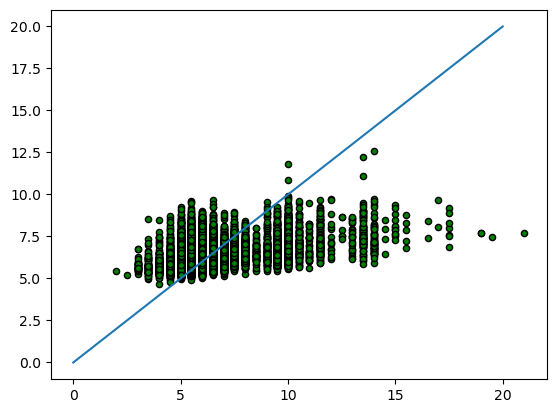

0.1354212153815001
0.17392551015116653


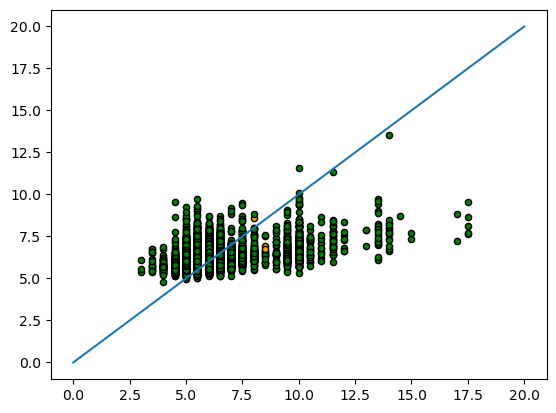

In [19]:
regr = MLPRegressor(max_iter = 400000, solver = 'lbfgs', hidden_layer_sizes = (8, 8), alpha = 500, verbose = True)

regr.fit(X_train, y_train)


y_train_predict = regr.predict(X_train)

plt.plot([0, 20], [0, 20])

plt.scatter(y_train[:, 0], y_train_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_train[:, 1], y_train_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_train[:, 0], y_train_predict[:, 0]))
print(r2_score(y_train[:, 1], y_train_predict[:, 1]))


plt.show()

y_test_predict = regr.predict(X_test)

plt.plot([0, 20], [0, 20])

plt.scatter(y_test[:, 0], y_test_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_test[:, 1], y_test_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_test[:, 0], y_test_predict[:, 0]))
print(r2_score(y_test[:, 1], y_test_predict[:, 1]))


plt.show()

Train neural network for outfield players.

The outputs of the NN are probability distribution of SinhArcsinh type (a skewed distribution, which is a generalization of Gaussian)

In [20]:
load_model_of = True# load scaler and model weights for outfield player predictor
refit_model_of = True

if(load_model_of):
    scaler = pickle.load(open('saves/scaler.pkl', 'rb'))
    
    X_train = scaler.transform(X_train_)
    X_test = scaler.transform(X_test_)


n_epochs = 1000

n_samples = X_train.shape[0]

batch_size = 256

X_len = X_train.shape[1]
y_len = y_train.shape[1]


#tailweight_param = 1.1

tailweight_min = 0.5
tailweight_range = 1.2


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)


inputs = tfk.layers.Input(shape=(X_len,), name="input")
x = tfk.layers.Dropout(0.2)(inputs)
x = tfk.layers.Dense(16, activation="relu") (x)
x = tfk.layers.Dropout(0.2)(x)
x = tfk.layers.Dense(16, activation="relu") (x)


prob_dist_params = 4

def prob_dist(t): 
    return tfp.distributions.SinhArcsinh(loc=t[..., 0], scale=1e-3 + tf.math.softplus(t[..., 1]), skewness = t[..., 2], 
                                        tailweight = tailweight_min + tailweight_range * tf.math.sigmoid(t[..., 3]),
                                        allow_nan_stats = False)

x1 = tfk.layers.Dense(8, activation="sigmoid")(x)
x1 = tfk.layers.Dense(prob_dist_params, activation="linear")(x1)
out_1 = tfp.layers.DistributionLambda(prob_dist)(x1)

x2 = tfk.layers.Dense(8, activation="sigmoid")(x)
x2 = tfk.layers.Dense(prob_dist_params, activation="linear")(x2)
out_2 = tfp.layers.DistributionLambda(prob_dist)(x2)


modelb = tf.keras.Model(inputs, [out_1, out_2])

modelb.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate = 0.001), 
              loss=neg_log_likelihood)

if(load_model_of):
    modelb.load_weights('saves/modelb')
    
if( (not load_model_of) or refit_model_of):
    modelb.fit(X_train.astype('float32'), [y_train[:, 0].astype('float32'), y_train[:, 1].astype('float32')], 
              validation_data = (X_test.astype('float32'), [y_test[:, 0].astype('float32'), y_test[:, 1].astype('float32')]),
              batch_size = batch_size, shuffle = True, epochs=n_epochs, verbose=True, callbacks = [callback])

Epoch 1/1000
97/97 [==============================] - 4s 9ms/step - loss: 2.1231 - distribution_lambda_loss: 0.8271 - distribution_lambda_1_loss: 1.2961 - val_loss: 2.0424 - val_distribution_lambda_loss: 0.7918 - val_distribution_lambda_1_loss: 1.2505
Epoch 2/1000
97/97 [==============================] - 0s 3ms/step - loss: 2.1228 - distribution_lambda_loss: 0.8266 - distribution_lambda_1_loss: 1.2962 - val_loss: 2.0378 - val_distribution_lambda_loss: 0.7895 - val_distribution_lambda_1_loss: 1.2483
Epoch 3/1000
97/97 [==============================] - 0s 3ms/step - loss: 2.1235 - distribution_lambda_loss: 0.8279 - distribution_lambda_1_loss: 1.2957 - val_loss: 2.0464 - val_distribution_lambda_loss: 0.7935 - val_distribution_lambda_1_loss: 1.2530
Epoch 4/1000
97/97 [==============================] - 0s 3ms/step - loss: 2.1266 - distribution_lambda_loss: 0.8293 - distribution_lambda_1_loss: 1.2973 - val_loss: 2.0375 - val_distribution_lambda_loss: 0.7873 - val_distribution_lambda_1_loss:

In [21]:
def sample_predict(X, iterations = 100):
    y = np.zeros((2, X.shape[0]))
    
    dist = modelb(X)
    
    for i in range(iterations):
        y[0, :] += dist[0].sample()
        y[1, :] += dist[1].sample()
        
    return y.transpose() / iterations
    

0.14318537713364876
0.16192383064613713


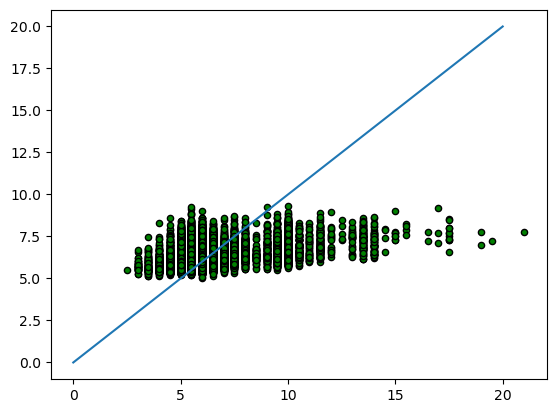

0.1390455990767111
0.16511344994051125


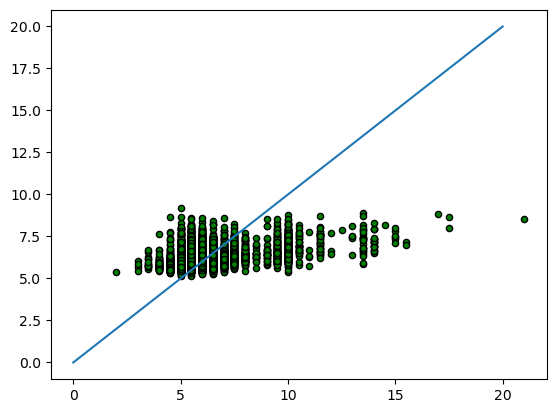

In [22]:
y_train_predict = sample_predict(X_train)

plt.plot([0, 20], [0, 20])

plt.scatter(y_train[:, 0], y_train_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_train[:, 1], y_train_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_train[:, 0], y_train_predict[:, 0]))
print(r2_score(y_train[:, 1], y_train_predict[:, 1]))

plt.show()

y_test_predict = sample_predict(X_test)

plt.plot([0, 20], [0, 20])

plt.scatter(y_test[:, 0], y_test_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_test[:, 1], y_test_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_test[:, 0], y_test_predict[:, 0]))
print(r2_score(y_test[:, 1], y_test_predict[:, 1]))




Train neural network for goalkeepers.

For clean sheet probability prediction, a Bernoulli distribution is used.

In [23]:
load_model_gk = True# load scaler and model weights for goalkeeper player predictor
refit_model_gk = True

if(load_model_gk):
    scaler_gk = pickle.load(open('saves/scaler_gk.pkl', 'rb'))
    
    X_gk_train = scaler_gk.transform(X_gk_train_)
    X_gk_test = scaler_gk.transform(X_gk_test_)
    
    
n_epochs = 2500

n_samples = X_gk_train.shape[0]

batch_size = 128

X_gk_len = X_gk_train.shape[1]
y_gk_len = y_gk_train.shape[1]


#tailweight_param = 1.1

tailweight_min = 0.5
tailweight_range = 0.8


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 50)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)


inputs = tfk.layers.Input(shape=(X_gk_len,), name="input")
x = tfk.layers.Dense(16, activation="relu") (inputs)
x = tfk.layers.Dropout(0.3)(x)
x = tfk.layers.Dense(16, activation="relu") (x)


prob_dist_params = 4

def prob_dist(t): 
    return tfp.distributions.SinhArcsinh(loc=t[..., 0], scale=1e-3 + tf.math.softplus(t[..., 1]), skewness = t[..., 2], 
                                        tailweight = tailweight_min + tailweight_range * tf.math.sigmoid(t[..., 3]),
                                        allow_nan_stats = False)

x1 = tfk.layers.Dense(16, activation="sigmoid")(x)
x1 = tfk.layers.Dropout(0.2)(x1)
x1 = tfk.layers.Dense(prob_dist_params, activation="linear")(x1)
out_1 = tfp.layers.DistributionLambda(prob_dist)(x1)

x2 = tfk.layers.Dense(16, activation="sigmoid")(x)

x2 = tfk.layers.Dense(prob_dist_params, activation="linear")(x2)
out_2 = tfp.layers.DistributionLambda(prob_dist)(x2)

x3 = tfk.layers.Dense(8, activation="sigmoid")(x)
x3 = tfk.layers.Dropout(0.2)(x3)
x3 = tfk.layers.Dense(1, activation="sigmoid")(x3)
out_3 = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Bernoulli(probs = t[..., 0]))(x3)

modelb_gk = tf.keras.Model(inputs, [out_1, out_2, out_3])

modelb_gk.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate = 0.001), 
              loss=neg_log_likelihood)

if(load_model_gk):
    modelb_gk.load_weights('saves/modelb_gk')

if( (not load_model_gk) or refit_model_gk):    
    modelb_gk.fit(X_gk_train.astype('float32'), [y_gk_train[:, 0].astype('float32'), y_gk_train[:, 1].astype('float32'), y_gk_train[:, 2].astype('int')], 
              validation_data = (X_gk_test.astype('float32'), [y_gk_test[:, 0].astype('float32'), y_gk_test[:, 1].astype('float32'), y_gk_test[:, 2].astype('int')]),
              batch_size = batch_size, shuffle = True, epochs=n_epochs, verbose=True, callbacks = [callback])

Epoch 1/2500
16/16 [==============================] - 4s 49ms/step - loss: 2.8318 - distribution_lambda_2_loss: 0.7818 - distribution_lambda_3_loss: 1.5811 - distribution_lambda_4_loss: 0.4689 - val_loss: 2.7879 - val_distribution_lambda_2_loss: 0.7363 - val_distribution_lambda_3_loss: 1.5952 - val_distribution_lambda_4_loss: 0.4564
Epoch 2/2500
16/16 [==============================] - 0s 4ms/step - loss: 2.8259 - distribution_lambda_2_loss: 0.7828 - distribution_lambda_3_loss: 1.5794 - distribution_lambda_4_loss: 0.4637 - val_loss: 2.7892 - val_distribution_lambda_2_loss: 0.7348 - val_distribution_lambda_3_loss: 1.5957 - val_distribution_lambda_4_loss: 0.4587
Epoch 3/2500
16/16 [==============================] - 0s 4ms/step - loss: 2.8180 - distribution_lambda_2_loss: 0.7852 - distribution_lambda_3_loss: 1.5736 - distribution_lambda_4_loss: 0.4592 - val_loss: 2.7863 - val_distribution_lambda_2_loss: 0.7288 - val_distribution_lambda_3_loss: 1.5961 - val_distribution_lambda_4_loss: 0.46

16/16 [==============================] - 0s 4ms/step - loss: 2.8392 - distribution_lambda_2_loss: 0.8073 - distribution_lambda_3_loss: 1.5790 - distribution_lambda_4_loss: 0.4529 - val_loss: 2.8279 - val_distribution_lambda_2_loss: 0.7351 - val_distribution_lambda_3_loss: 1.6155 - val_distribution_lambda_4_loss: 0.4772
Epoch 26/2500
16/16 [==============================] - 0s 4ms/step - loss: 2.8193 - distribution_lambda_2_loss: 0.7785 - distribution_lambda_3_loss: 1.5722 - distribution_lambda_4_loss: 0.4686 - val_loss: 2.8286 - val_distribution_lambda_2_loss: 0.7346 - val_distribution_lambda_3_loss: 1.6168 - val_distribution_lambda_4_loss: 0.4772
Epoch 27/2500
16/16 [==============================] - 0s 4ms/step - loss: 2.8056 - distribution_lambda_2_loss: 0.7836 - distribution_lambda_3_loss: 1.5648 - distribution_lambda_4_loss: 0.4572 - val_loss: 2.8276 - val_distribution_lambda_2_loss: 0.7344 - val_distribution_lambda_3_loss: 1.6166 - val_distribution_lambda_4_loss: 0.4767
Epoch 28/

16/16 [==============================] - 0s 4ms/step - loss: 2.7817 - distribution_lambda_2_loss: 0.7642 - distribution_lambda_3_loss: 1.5567 - distribution_lambda_4_loss: 0.4608 - val_loss: 2.8588 - val_distribution_lambda_2_loss: 0.7381 - val_distribution_lambda_3_loss: 1.6305 - val_distribution_lambda_4_loss: 0.4902
Epoch 50/2500
16/16 [==============================] - 0s 4ms/step - loss: 2.7974 - distribution_lambda_2_loss: 0.7894 - distribution_lambda_3_loss: 1.5578 - distribution_lambda_4_loss: 0.4502 - val_loss: 2.8586 - val_distribution_lambda_2_loss: 0.7389 - val_distribution_lambda_3_loss: 1.6301 - val_distribution_lambda_4_loss: 0.4896
Epoch 51/2500
16/16 [==============================] - 0s 4ms/step - loss: 2.7851 - distribution_lambda_2_loss: 0.7654 - distribution_lambda_3_loss: 1.5580 - distribution_lambda_4_loss: 0.4616 - val_loss: 2.8592 - val_distribution_lambda_2_loss: 0.7364 - val_distribution_lambda_3_loss: 1.6328 - val_distribution_lambda_4_loss: 0.4899
Epoch 52/

In [24]:
def sample_predict_gk(X, iterations = 100):
    y = np.zeros((3, X.shape[0]))
    
    dist = modelb_gk(X)
    
    for i in range(iterations):
        y[0, :] += dist[0].sample()
        y[1, :] += dist[1].sample()
        y[2, :] += dist[2].sample()
        
    return y.transpose() / iterations


0.11125466234353387
0.31109318411388387


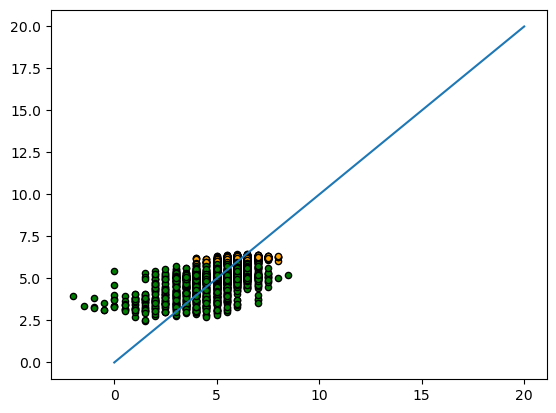

0.04536015796966664
0.23520934604862653


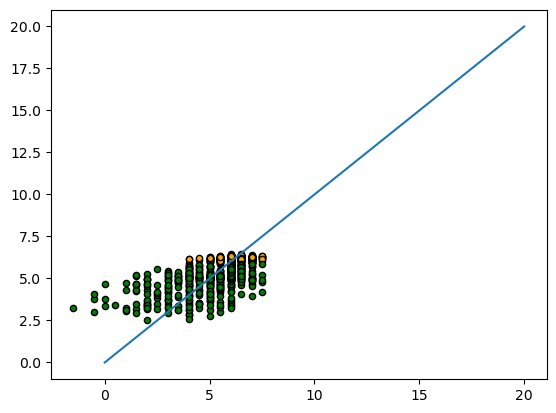

In [25]:
y_gk_train_predict = sample_predict_gk(X_gk_train)

plt.plot([0, 20], [0, 20])

plt.scatter(y_gk_train[:, 0], y_gk_train_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_gk_train[:, 1], y_gk_train_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_gk_train[:, 0], y_gk_train_predict[:, 0]))
print(r2_score(y_gk_train[:, 1], y_gk_train_predict[:, 1]))

plt.show()

y_gk_test_predict = sample_predict_gk(X_gk_test)

plt.plot([0, 20], [0, 20])

plt.scatter(y_gk_test[:, 0], y_gk_test_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_gk_test[:, 1], y_gk_test_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_gk_test[:, 0], y_gk_test_predict[:, 0]))
print(r2_score(y_gk_test[:, 1], y_gk_test_predict[:, 1]))




Use the following codes to save the scalers and the model weights

In [26]:
save_model_of = True
save_model_gk = True

if(save_model_of):
    pickle.dump(scaler, open('saves/scaler.pkl', 'wb'))
    modelb.save_weights('saves/modelb')
    
if(save_model_gk):
    pickle.dump(scaler_gk, open('saves/scaler_gk.pkl', 'wb'))
    modelb_gk.save_weights('saves/modelb_gk')
    

Generalized prediction function for a player (playing for team against opp_team, at home or not)

Estimate prediction mean and sigma (using a custom definitions).

Generate a plot.


In [27]:
def vote_predict_NNb(player, team, opp_team, home = 1, plot = 0, log = 0, oldseason = False):
    if(players['r'][player] == 'P'):
        ptest = player_match_data_ext_gk(player, team, opp_team, oldseason = oldseason)

        x_ptest = np.array(ptest)[:, 3:]
        r = np.array(ptest)[0, 0]

        # add home and role
        xadd = np.zeros((1, 1))
        xadd[0, 0] = home

        x_ptest = np.concatenate((x_ptest, xadd), axis = 1)

        x_scaled = scaler_gk.transform(x_ptest)

        dist = modelb_gk(x_scaled)
        
        clean_shoot_prob = dist[2].probs.numpy()[0]
    else:
        ptest = player_match_data_ext(player, team, opp_team, oldseason = oldseason)

        x_ptest = np.array(ptest)[:, 4:]
        r = np.array(ptest)[0, 0]

        # add home and role
        xadd = np.zeros((1, 4))
        xadd[0, 0] = home
        xadd[0, 1] = r == 'D'
        xadd[0, 2] = r == 'C'
        xadd[0, 3] = r == 'A'

        x_ptest = np.concatenate((x_ptest, xadd), axis = 1)

        x_scaled = scaler.transform(x_ptest)

        dist = modelb(x_scaled)
    
    
    x = np.arange(0, 40, 0.002)

    px1 = dist[0].prob(x);
    px2 = dist[1].prob(x);

    
    #sample1 = dist[0].sample(10000)
    #sample2 = dist[1].sample(10000)
    
    m1 = np.average(x, weights = px1)
    m2 = np.average(x, weights = px2)
    
    #m1 = np.mean(sample1)
    #m2 = np.mean(sample2)
    
    #s1 = np.std(sample1)
    #s2 = np.std(sample2)
      
    # not standard deviation, but expected range extimated by quantile 
    
    if(players['r'][player] == 'P'):
        s1 = ( dist[0].quantile(0.9545) - m1 ) / 2
        s2 = -( dist[1].quantile(1 - 0.9) - m2 ) / 2
    else:
        s1 = ( dist[0].quantile(0.9545) - m1 ) / 2
        s2 = ( dist[1].quantile(0.9) - m2 ) / 2
    

    
    #y_pred_m = np.array([dist[0].loc, dist[1].loc]).flatten()
    y_pred_m = np.array([m1, m2]).flatten()
    #y_pred_s = np.array([dist[0].scale, dist[1].scale]).flatten()
    y_pred_s = np.array([s1, s2]).flatten()
    
    clean_sheet_text = ''
    if(players['r'][player] == 'P'):
        clean_sheet_text = ' (' + "{:.1f}".format(clean_shoot_prob*100) + '% cs)'
            
    if(plot):
        ax = plt.gca()
        
        plt.plot(x, px1, 
                 label = 'MV ' + "{:.2f}".format(y_pred_m[0]) + ' ± ' + "{:.2f}".format(2 * y_pred_s[0]),
                color = 'b')
        plt.plot(x, px2, 
                 label = 'FV ' + "{:.2f}".format(y_pred_m[1]) + ' + ' + "{:.2f}".format(2 * y_pred_s[1]) + clean_sheet_text,
                color = 'g')
        
        plt.fill_between(x, px1, color = 'lightblue')
        plt.fill_between(x, px2, color = 'lightgreen')
        
        plt.legend()
        
        plt.vlines(x = y_pred_m[0], color = 'b', ymin = 0, ymax = 3, linestyle = 'dashed')
        plt.vlines(x = y_pred_m[1], color = 'g', ymin = 0, ymax = 3, linestyle = 'dashed')
        
        plt.title(player + ' (' + team + ' vs ' + opp_team + ')')
        
        plt.xlim([0, 15])
        
        if(players['r'][player] == 'P'):            
            plt.ylim([0, 2.5])
        else:
            plt.ylim([0, 1.5])
        
        plt.show()
        
    if(log):
        print(player + ': ' + 
         'MV ' + "{:.2f}".format(y_pred_m[0]) + ' ± ' + "{:.2f}".format(2 * y_pred_s[0]) +
         '; FV ' + "{:.2f}".format(y_pred_m[1]) + ' + ' + "{:.2f}".format(2 * y_pred_s[1]) + clean_sheet_text);
    return [y_pred_m, y_pred_s, dist]


Load Serie A calendar. 

In [28]:
cal = np.array(pd.read_excel('fantacalcio/seriea_calendar.xlsx', header = None))

cal_df = pd.DataFrame(columns = ['matchday', 'team1', 'team2'])

matchday = 0

for i in range(cal.shape[0]):
    if(cal[i, 0][0].isnumeric()):
        matchday = matchday + 1
        continue
    
    teams = cal[i, 0].split('-')
    
    frame = pd.DataFrame([[matchday, teams[0], teams[1]]], columns = cal_df.columns)

    cal_df = pd.concat([cal_df, frame], ignore_index = True)
    

In [29]:
print(cal_df.to_string())

    matchday        team1        team2
0          1      Bologna        Milan
1          1       Empoli       Verona
2          1    Frosinone       Napoli
3          1        Genoa   Fiorentina
4          1        Inter        Monza
5          1        Lecce        Lazio
6          1         Roma  Salernitana
7          1     Sassuolo     Atalanta
8          1       Torino     Cagliari
9          1      Udinese     Juventus
10         2     Cagliari        Inter
11         2   Fiorentina        Lecce
12         2    Frosinone     Atalanta
13         2       Verona         Roma
14         2     Juventus      Bologna
15         2        Lazio        Genoa
16         2        Milan       Torino
17         2        Monza       Empoli
18         2       Napoli     Sassuolo
19         2  Salernitana      Udinese
20         3     Atalanta        Monza
21         3      Bologna     Cagliari
22         3       Empoli     Juventus
23         3        Inter   Fiorentina
24         3        Lecce

Function for generating a prediction for a player, taking match data from a given matchday, according to Serie A calendar.

In [30]:
def PlayerMatch(player, match = 0):
    team = players.loc[player]['team']
    
    if(match == 0):
        oppteam = 'Avg'
        home = 1
    else:
        for i in range (cal_df.shape[0]):
            if(cal_df['matchday'][i] == match):
                if(cal_df['team1'][i] == team):
                    home = 1
                    oppteam = cal_df['team2'][i]
                elif(cal_df['team2'][i] == team):
                    home = 0
                    oppteam = cal_df['team1'][i]
                
    return [player, team, oppteam, home]

def predict_player(player, match = 0, plot = 0, log = 0, oldseason = False):
    [player, team, oppteam, home] = PlayerMatch(player, match)
    return vote_predict_NNb(player, team, oppteam, home = home, plot = plot, log = log, oldseason = oldseason)

Load current matchday playing probabilities for Serie A players.

In [31]:
probables = pd.read_excel('mid_outputs/match_probable_players.xlsx', index_col = 0)   

probables

,starter,percentage
player,,
Berisha,1.0,90
Ebuehi,1.0,90
Ismajli,1.0,80
Luperto,1.0,90
Bastoni S.,1.0,85
...,...,...
Ikone',0.0,30
Barak,0.0,40
Sottil,0.0,40


Generate prediction data for each Serie A player for the current matchday.

Output to excel file, using a template made for data elaboration.

In [32]:
matchday_out = 8

output = pd.DataFrame(columns = ['player', 'role', 'team', 'oppteam', 'home', 'starter', 'vote%', 'MV', 'MV std', 'FV', 'FV std', 'MV loc', 'MV scale', 'MV skewness', 'MV tailweight', 'FV loc', 'FV scale', 'FV skewness', 'FV tailweight', 'Clean Sheet %'])

for i in range(players.shape[0]):
    try:
        [player, team, oppteam, home] = PlayerMatch(players.index[i], matchday_out)
        
        [mean, std, dist] = vote_predict_NNb(player, team, oppteam, home = home, log = 1)
        
        role = players['r'][player] 
        
        starter = 0
        voteperc = 0
        
        cs = 0
        if(role == 'P'):
            cs = dist[2].probs.numpy()[0] * 100
        
        if(player in probables.index):
            starter = probables['starter'][player]
            voteperc = probables['percentage'][player]
        
        row = [player, role, team, oppteam, home, 
               starter, voteperc, 
               mean[0], std[0], 
               mean[1], std[1], 
               dist[0].loc.numpy()[0], dist[0].scale.numpy()[0], 
               dist[0].skewness.numpy()[0], dist[0].tailweight.numpy()[0], 
               dist[1].loc.numpy()[0], dist[1].scale.numpy()[0], 
               dist[1].skewness.numpy()[0], dist[1].tailweight.numpy()[0],
               cs]
        
        row_df = pd.DataFrame(data = [row], columns = output.columns)
        
        output = pd.concat([output, row_df])
        
    except:
        print(players.index[i] + ' no data')

output = output.set_index('player')

output = output.sort_values(['team', 'role', 'FV'], ascending = [True, False, False])
#output.to_excel('outputs/pred_matchday_' + str(matchday_out) + '.xlsx')

output

Sommer: MV 6.20 ± 0.78; FV 5.60 + 1.26 (63.2% cs)
Skorupski: MV 6.03 ± 0.91; FV 3.80 + 2.05 (1.6% cs)
Di Gregorio: MV 6.14 ± 0.77; FV 5.73 + 1.28 (74.7% cs)
Meret: MV 5.71 ± 0.99; FV 3.10 + 2.68 (0.8% cs)
Provedel: MV 6.21 ± 0.87; FV 4.88 + 1.44 (16.7% cs)
Terracciano: MV 6.19 ± 0.82; FV 4.74 + 1.52 (12.4% cs)
Szczesny: MV 6.14 ± 0.81; FV 5.53 + 1.26 (59.4% cs)
Falcone: MV 6.15 ± 0.86; FV 4.98 + 1.40 (14.9% cs)
Milinkovic-Savic V.: MV 6.24 ± 0.90; FV 5.07 + 1.60 (25.0% cs)
Maignan: MV 6.20 ± 0.93; FV 5.10 + 1.50 (22.0% cs)
Montipo': MV 6.16 ± 0.86; FV 4.97 + 1.38 (27.6% cs)
Rui Patricio: MV 6.16 ± 0.79; FV 5.03 + 1.35 (17.8% cs)
Turati: MV 6.12 ± 0.90; FV 4.97 + 1.37 (22.7% cs)
Consigli: MV 6.15 ± 0.91; FV 4.03 + 2.07 (2.8% cs)
Musso: MV 6.13 ± 0.79; FV 5.56 + 1.26 (54.3% cs)
Carnesecchi: MV 6.11 ± 0.85; FV 5.00 + 1.36 (21.2% cs)
Radunovic: MV 5.35 ± 1.05; FV 2.98 + 2.92 (0.9% cs)
Silvestri: MV 6.16 ± 0.80; FV 5.63 + 1.27 (59.2% cs)
Martinez Jo.: MV 6.04 ± 0.91; FV 3.74 + 2.11 (1.9% cs

Vina: MV 5.69 ± 1.01; FV 5.70 + 1.15
Obert: MV 5.66 ± 0.99; FV 5.55 + 1.08
Tressoldi: MV 5.92 ± 0.89; FV 5.98 + 1.08
Dossena: MV 5.51 ± 1.04; FV 5.39 + 1.15
Oyono: MV 5.92 ± 0.56; FV 5.90 + 0.46
Touba: MV 5.99 ± 0.82; FV 6.06 + 1.05
Sazonov: MV 5.89 ± 0.72; FV 5.92 + 0.81
Patric: MV 5.84 ± 0.68; FV 5.80 + 0.68
Pezzella Giu.: MV 5.77 ± 0.68; FV 5.70 + 0.68
Ferrari G.: MV 5.82 ± 0.85; FV 5.88 + 1.04
Venuti: MV 5.89 ± 0.67; FV 5.87 + 0.74
Karsdorp: MV 5.99 ± 0.54; FV 6.02 + 0.52
Kjaer: MV 5.67 ± 1.21; FV 5.53 + 1.21
Lykogiannis: MV 5.53 ± 0.72; FV 5.47 + 0.65
Walukiewicz: MV 5.78 ± 0.89; FV 5.71 + 0.94
Okoli: MV 5.89 ± 0.75; FV 5.87 + 0.69
Amione: MV 5.90 ± 0.85; FV 5.95 + 1.05
Di Pardo: MV 5.73 ± 0.92; FV 5.66 + 0.99
Hefti: MV 5.60 ± 1.00; FV 5.51 + 0.98
Ehizibue: MV 6.03 ± 0.88; FV 6.28 + 1.33
Vogliacco: MV 5.81 ± 1.11; FV 5.83 + 1.30
Rugani: MV 6.03 ± 0.53; FV 6.04 + 0.48
Goldaniga: MV 5.65 ± 1.17; FV 5.51 + 1.34
Pereira P.: MV 6.13 ± 0.83; FV 6.21 + 1.00
Fazio: MV 5.82 ± 1.13; FV 5.90

Baez: MV 5.93 ± 0.55; FV 5.92 + 0.47
Sensi: MV 6.10 ± 0.81; FV 6.33 + 1.10
Maleh: MV 5.72 ± 0.97; FV 5.83 + 1.25
Adli: MV 6.08 ± 1.00; FV 6.26 + 1.33
Gonzalez J.: MV 5.88 ± 0.71; FV 5.94 + 0.92
Serdar: MV 5.91 ± 0.66; FV 5.92 + 0.74
Suslov: MV 6.02 ± 0.68; FV 6.07 + 0.78
Viola: MV 5.89 ± 0.96; FV 5.86 + 1.10
Deiola: MV 5.51 ± 0.88; FV 5.48 + 0.82
Bourabia: MV 6.04 ± 0.68; FV 6.10 + 0.68
Saelemaekers: MV 5.70 ± 0.97; FV 5.81 + 1.18
Maldini: MV 6.11 ± 0.84; FV 6.42 + 1.36
Maggiore: MV 5.89 ± 0.52; FV 5.86 + 0.50
Racic: MV 6.03 ± 0.92; FV 6.15 + 1.15
Kovalenko: MV 6.03 ± 0.68; FV 6.07 + 0.68
Romero L.: MV 6.06 ± 0.98; FV 6.27 + 1.39
Asllani: MV 5.94 ± 0.55; FV 5.92 + 0.46
Vignato S.: MV 5.94 ± 0.64; FV 5.93 + 0.63
Ranocchia F.: MV 5.97 ± 0.57; FV 6.06 + 0.63
Sulemana I.: MV 5.69 ± 0.69; FV 5.62 + 0.71
Infantino: MV 5.87 ± 0.98; FV 5.95 + 1.19
Tchatchoua: MV 5.96 ± 0.92; FV 6.07 + 1.17
Quina: MV 6.14 ± 0.73; FV 6.25 + 0.85
Adopo: MV 5.99 ± 0.90; FV 6.10 + 1.10
Basic: MV 5.94 ± 0.70; FV 5.9

,role,team,oppteam,home,starter,vote%,MV,MV std,FV,FV std,MV loc,MV scale,MV skewness,MV tailweight,FV loc,FV scale,FV skewness,FV tailweight,Clean Sheet %
player,,,,,,,,,,,,,,,,,,,
Musso,P,Atalanta,Lazio,0,1.00,70,6.130588,0.395458,5.560176,0.630095,6.117671,0.473347,0.020254,1.189104,6.219871,0.682691,-0.651437,1.180653,54.287124
Rossi F.,P,Atalanta,Lazio,0,0.00,1,6.130588,0.395458,5.560176,0.630095,6.117671,0.473347,0.020254,1.189104,6.219871,0.682691,-0.651437,1.180653,54.287124
Carnesecchi,P,Atalanta,Lazio,0,0.00,5,6.111842,0.423985,4.999980,0.679832,6.061238,0.492138,0.076215,1.184612,5.243609,1.016311,-0.176309,1.051638,21.158487
Ruggeri,D,Atalanta,Lazio,0,0.55,55,6.146059,0.491973,6.431080,0.748339,6.130273,0.571970,0.020303,0.888866,5.914506,1.029078,0.360306,1.299918,0.000000
Zortea,D,Atalanta,Lazio,0,0.00,30,6.049477,0.421663,6.325981,0.639571,6.005404,0.484718,0.066981,0.952244,5.874121,0.871703,0.371244,1.299916,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Henry,A,Verona,Frosinone,0,0.00,40,5.930722,0.516654,6.314850,0.830392,5.676789,0.529371,0.347378,0.843730,5.485209,0.900312,0.617425,1.299930,0.000000
Djuric,A,Verona,Frosinone,0,0.45,55,5.990664,0.324370,6.125685,0.401414,5.981859,0.383508,0.016978,1.054538,5.903392,0.589155,0.274942,1.299901,0.000000
Kallon,A,Verona,Frosinone,0,0.00,0,5.866126,0.445314,6.106137,0.610579,5.668099,0.458100,0.313946,0.919495,5.532506,0.703259,0.557121,1.299925,0.000000


In [33]:
import shutil

template_file = 'outputs/pred_matchday_base.xlsx'
dest_file = 'outputs/pred_matchday_' + str(matchday_out) + '.xlsx'

shutil.copyfile(template_file, dest_file)

with pd.ExcelWriter(dest_file, mode = 'a', engine="openpyxl", if_sheet_exists = 'replace') as writer:  
    output.to_excel(writer, sheet_name='data')

Predict average Serie A performance for each player

In [34]:
gk_starters = ['Maignan', 'Ochoa', 'Silvestri', 'Consigli', 'Provedel', 'Di Gregorio', 'Meret', 'Milinkovic-Savic V.',
              'Terracciano', 'Sommer', 'Szczesny', 'Skorupski', 'Berisha', 'Musso', 'Radunovic', 'Rui Patricio',
              'Montipo\'', 'Falcone', 'Martinez Jo.', 'Turati']

In [ ]:
output = pd.DataFrame(columns = ['player', 'role', 'team', 'oppteam', 'home', 'starter', 'vote%', 'MV', 'MV std', 'FV', 'FV std', 'MV loc', 'MV scale', 'MV skewness', 'MV tailweight', 'FV loc', 'FV scale', 'FV skewness', 'FV tailweight', 'Clean Sheet %'])

tot_matches = 2 # home and not home

current_season_games = max(players_orig['games'])

for i in range(players.shape[0]):
    try:
        home = 0

        for k in range(tot_matches):
            #matchday_out = k + 1
            #[player, team, oppteam, home] = PlayerMatch(players.index[i], matchday_out)

            player = players.index[i]
            team = players['team'][i]
            oppteam = 'Avg'
            home = not home

            [mean, std, dist] = vote_predict_NNb(player, team, oppteam, home = home)

            role = players['r'][player] 

            starter = 0
            voteperc = 0

            games = max( players_orig['games'][i], players_orig['gk_games'][i] )
            mins = max( players_orig['minutes'][i], players_orig['gk_minutes'][i] )

            cs = 0
            if(role == 'P'):
                cs = dist[2].probs.numpy()[0] * 100

                starter = int( player in gk_starters )
                if(starter):
                    voteperc = 100
                else:
                    voteperc = 0
            else:
                starter = int ( 1 * (games >= current_season_games * 2/3 and mins / games >= 45 ) )
                voteperc = int( min( 1, games / current_season_games ) * 100)     

            if(k == 0):
                row = [player, role, team, 'Avg', 1, starter, voteperc]

            numrow_ = [mean[0], std[0], 
                   mean[1], std[1], 
                   dist[0].loc.numpy()[0], dist[0].scale.numpy()[0], 
                   dist[0].skewness.numpy()[0], dist[0].tailweight.numpy()[0], 
                   dist[1].loc.numpy()[0], dist[1].scale.numpy()[0], 
                   dist[1].skewness.numpy()[0], dist[1].tailweight.numpy()[0],
                   cs]            

            if(k == 0):
                numrow = numrow_
            else:
                for j in range(len(numrow)):
                    numrow[j] += numrow_[j]

        for j in range(len(numrow)):
            numrow[j] /= tot_matches

        print(players.index[i] + ' (' + "{:.2f}".format(numrow[0]) + ', ' + "{:.2f}".format(numrow[1]) + 
              '); (' + "{:.2f}".format(numrow[2]) + ', ' + "{:.2f}".format(numrow[3]) + ')' )

        row += numrow # list concat

        row_df = pd.DataFrame(data = [row], columns = output.columns)

        output = pd.concat([output, row_df])
    except:
        print(players.index[i] + ' no data')
    
        

output = output.set_index('player')

output = output.sort_values(['team', 'role', 'FV'], ascending = [True, False, False])
#output.to_excel('outputs/pred_matchday_' + str(matchday_out) + '.xlsx')

output

Sommer (6.17, 0.41); (5.61, 0.63)
Skorupski (6.12, 0.40); (5.49, 0.63)
Di Gregorio (6.15, 0.50); (4.97, 0.69)
Meret (6.00, 0.44); (4.56, 0.83)
Provedel (6.20, 0.45); (4.52, 0.86)
Terracciano (6.18, 0.43); (5.13, 0.66)
Szczesny (6.16, 0.40); (5.66, 0.63)
Falcone (6.19, 0.45); (5.02, 0.71)
Milinkovic-Savic V. (6.18, 0.41); (5.09, 0.66)
Maignan (6.19, 0.47); (4.98, 0.69)
Montipo' (6.17, 0.39); (5.19, 0.64)
Rui Patricio (5.84, 0.46); (3.85, 1.05)
Turati (6.20, 0.48); (4.97, 0.72)
Consigli (6.04, 0.46); (4.02, 1.02)
Musso (6.18, 0.38); (5.69, 0.64)
Carnesecchi (6.14, 0.43); (5.01, 0.68)
Radunovic (6.04, 0.44); (4.57, 0.88)
Silvestri (5.65, 0.47); (3.63, 1.23)
Martinez Jo. (6.08, 0.44); (4.57, 0.89)
Ochoa (6.14, 0.46); (3.61, 1.16)
Sportiello (6.16, 0.43); (5.06, 0.67)
Berisha (6.06, 0.46); (3.55, 1.19)
Caprile (6.11, 0.45); (3.83, 1.08)
Perin (6.16, 0.41); (5.15, 0.65)
Cragno (6.03, 0.46); (3.63, 1.14)
Mirante (6.19, 0.47); (4.98, 0.69)
Sepe (6.20, 0.45); (4.52, 0.86)
Leali (6.08, 0.44); (4

Tonelli (5.62, 0.47); (5.53, 0.49)
De Sciglio (5.88, 0.31); (5.86, 0.29)
Capradossi (5.89, 0.46); (5.93, 0.54)
Bonifazi (5.85, 0.38); (5.80, 0.38)
Donati (5.95, 0.66); (6.01, 0.76)
Bettella (5.95, 0.44); (6.03, 0.54)
Kumbulla (5.52, 0.73); (5.28, 0.68)
Celik (5.73, 0.45); (5.67, 0.47)
Amey (5.94, 0.43); (6.00, 0.54)
Cittadini (5.95, 0.44); (6.03, 0.54)
Gila (5.88, 0.40); (5.86, 0.43)
Ebosse (5.82, 0.31); (5.77, 0.32)
Bronn (5.64, 0.42); (5.55, 0.42)
Guarino (5.81, 0.49); (5.88, 0.60)
Carboni F. (5.97, 0.42); (6.02, 0.49)
Smajlovic (5.93, 0.45); (6.00, 0.55)
Matturro (5.88, 0.49); (5.86, 0.53)
N'guessan (5.95, 0.43); (6.03, 0.52)
Mateus Lusuardi (5.93, 0.45); (6.00, 0.54)
Kalaj (5.93, 0.45); (6.00, 0.54)
Pierozzi (5.98, 0.46); (6.08, 0.57)
Huijsen (5.97, 0.43); (6.06, 0.53)
Bonfanti (6.00, 0.43); (6.11, 0.54)
Pellegrino (5.98, 0.44); (6.07, 0.54)
Comuzzo (5.98, 0.46); (6.08, 0.57)
Bartesaghi (6.03, 0.41); (6.10, 0.48)
Koopmeiners (6.33, 0.55); (6.94, 1.12)
Zielinski (6.34, 0.47); (6.77,

In [ ]:
import shutil

output = output.sort_values(['role', 'FV'], ascending = [False, False])

template_file = 'outputs/pred_matchday_base.xlsx'
dest_file = 'outputs/pred_avg_seriea.xlsx'

shutil.copyfile(template_file, dest_file)

with pd.ExcelWriter(dest_file, mode = 'a', engine="openpyxl", if_sheet_exists = 'replace') as writer:  
    output.to_excel(writer, sheet_name='data')

Various predictions.

In [54]:
predict_player('Meret', log = 1, plot = 0)
predict_player('Szczesny', log = 1, plot = 0)
predict_player('Provedel', log = 1, plot = 0)
predict_player('Maignan', log = 1, plot = 0)
predict_player('Rui Patricio', log = 1, plot = 0)
predict_player('Sommer', log = 1, plot = 0)
predict_player('Milinkovic-Savic V.', log = 1, plot = 0)
predict_player('Musso', log = 1, plot = 0)
predict_player('Caprile', log = 1, plot = 0)
predict_player('Silvestri', log = 1, plot = 0)
predict_player('Terracciano', log = 1, plot = 0)
predict_player('Skorupski', log = 1, plot = 0)
predict_player('Falcone', log = 1, plot = 0)
predict_player('Di Gregorio', log = 1, plot = 0)
predict_player('Consigli', log = 1, plot = 0)
predict_player('Radunovic', log = 1, plot = 0)
predict_player('Montipo\'', log = 1, plot = 0)
predict_player('Martinez Jo.', log = 1, plot = 0)
predict_player('Turati', log = 1, plot = 0)
predict_player('Ochoa', log = 1, plot = 0)

Meret: MV 5.90 ± 1.55; FV 5.53 + 1.18 (43.4% cs)
Szczesny: MV 5.90 ± 1.55; FV 5.54 + 1.23 (53.7% cs)
Provedel: MV 5.89 ± 1.56; FV 5.03 + 1.63 (28.1% cs)
Maignan: MV 5.90 ± 1.55; FV 5.21 + 1.44 (29.1% cs)
Rui Patricio: MV 5.84 ± 1.66; FV 3.89 + 2.53 (10.0% cs)
Sommer: MV 5.90 ± 1.55; FV 5.57 + 1.20 (57.7% cs)
Milinkovic-Savic V.: MV 5.85 ± 1.64; FV 5.11 + 1.72 (40.7% cs)
Musso: MV 5.90 ± 1.55; FV 5.60 + 1.35 (58.3% cs)
Caprile: MV 5.86 ± 1.61; FV 3.99 + 2.22 (6.3% cs)
Silvestri: MV 5.90 ± 1.55; FV 5.19 + 1.44 (32.8% cs)
Terracciano: MV 5.88 ± 1.58; FV 4.24 + 2.15 (16.7% cs)
Skorupski: MV 5.89 ± 1.57; FV 4.48 + 2.02 (22.3% cs)
Falcone: MV 5.90 ± 1.55; FV 5.32 + 1.44 (38.7% cs)
Di Gregorio: MV 5.90 ± 1.55; FV 5.21 + 1.54 (32.9% cs)
Consigli: MV 5.79 ± 1.73; FV 3.82 + 2.56 (8.2% cs)
Radunovic: MV 5.71 ± 1.90; FV 4.24 + 2.26 (21.5% cs)
Montipo': MV 5.87 ± 1.59; FV 4.34 + 2.10 (16.6% cs)
Martinez Jo.: MV 5.90 ± 1.55; FV 5.24 + 1.34 (27.6% cs)
Turati: MV 5.90 ± 1.55; FV 5.04 + 1.48 (22.6% cs)

[array([5.89767402, 4.95480099]),
 array([0.7759559 , 0.77737534], dtype=float32),
 [<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=int32>]]

In [37]:
predict_player('Osimhen', log = 1)
predict_player('Osimhen', log = 1, oldseason= True)

Osimhen: MV 6.47 ± 1.49; FV 7.95 + 4.15
Osimhen: MV 6.48 ± 1.46; FV 8.08 + 4.29


[array([6.48246781, 8.07706693]),
 array([0.72848487, 2.14604   ], dtype=float32),
 [<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>]]

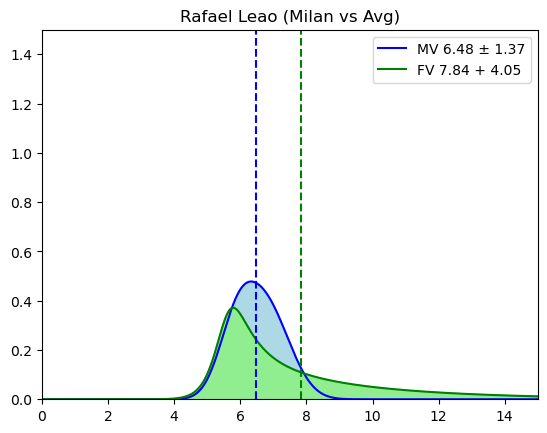

Rafael Leao: MV 6.48 ± 1.37; FV 7.84 + 4.05


[array([6.48351824, 7.84102121]),
 array([0.6832447, 2.0243561], dtype=float32),
 [<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>]]

In [56]:
predict_player('Rafael Leao', plot = 1, log = 1)

Tensorflow seems to have a custom definition for SinhArcsinh distribution. 

Here the code to generate the probability density function is reproduced.

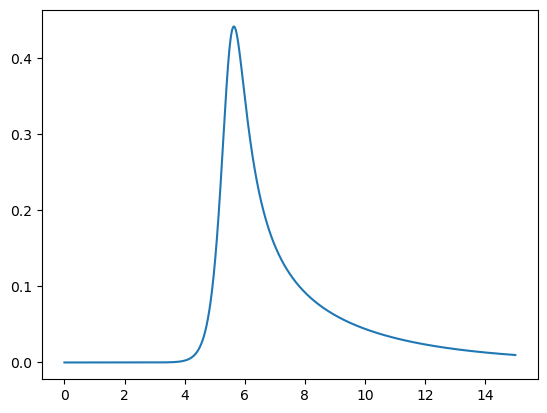

In [110]:
# custom franction to calculate the probability density function

def sinh_archsinh_pdf(x, mu, sigma, eps, delta):

    mul = np.sinh( np.arcsinh(2) * delta)
    
    mul = 2 / mul
    
    sigma_corr = sigma * mul
    
    z = (x - mu) / sigma_corr
    
    
    
    S = np.sinh( -eps + (1/delta) * np.arcsinh(z))
    
    f = np.exp(-0.5 * S * S)

    f /= np.sqrt(2 * np.pi)
    
    f *= 1 / ( sigma_corr * delta )
    
    f *= np.sqrt(1 + S * S)
    
    f /= np.sqrt(1 + z * z)
    
    return f
    

x = np.arange(start = 0, stop = 15, step = 0.001)


plt.plot(x, sinh_archsinh_pdf(x, 5.54, 1.4, 0.8, 1.68))


